# ECoG Forecasting with Sequence-to-Sequence (seq2seq) RNN models.

## Starting small: 1 channel.

In [1]:
#!/usr/bin/env python
# coding: utf-8

from aopy import datareader, datafilter
from ecog_is2s import EcogDataloader, Training, Encoder, Decoder, Seq2Seq, Util

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler, BatchSampler, SubsetRandomSampler
from torch.utils.data import TensorDataset, random_split

import spacy
import numpy as np
import pandas as pd
# import sklearn
import scipy as sp

import random
import math
import time

# import progressbar as pb
import datetime
import os
import sys
import csv
from itertools import product

import pickle as pkl

import argparse
import matplotlib.pyplot as plt

The code in the next cell is used to parse command line arguments. These arguments assign values to the network and training parameters. This functionality has been replaced with more hard-coded constants in the current notebook. From an organizational standpoint, that's not the worst thing - it's given me a good opportunity to collect all of the constants together into one single code block @ the top of the notebook. They were pretty scattershot before that.

In [2]:
# # grab input arguments
# parser = argparse.ArgumentParser('Trains a seq2seq network on a section of example NHP PMC ECoG data.',add_help=True)
# parser.add_argument('--encoder-depth', metavar='el', type=int, default=10, help='Sequence depth of the encoder network')
# parser.add_argument('--decoder-depth', metavar='dl', type=int, default=1, help='Sequence depth of the decoder network')
# parser.add_argument('--batch-size', metavar='b', type=int, default=1, help='Data batch size')
# parser.add_argument('--num-epochs', metavar='n', type=int, default=1, help='Number of optimization epochs')
# parser.add_argument('--num-layers', metavar='nl', type=int, default=1, help='Number of layers in each RNN block')

# args = parser.parse_args() # this bad boy has all the values packed into it. Nice!
# print(args.encoder_depth,args.decoder_depth)

# print(args.encoder_depth,args.decoder_depth)

### TO-DO:
Clean this mess up! There are lots of copied values and variable rereferences. They're unncessary and confusing.

In [3]:
# define constants
T_MINUTES = 2
ENCODER_DEPTH = 250
DECODER_DEPTH = 50
n_units =[2**10,2**11]
BATCH_SIZE = 100
NUM_EPOCHS = 1500
N_EPOCHS = NUM_EPOCHS
n_layers = [1,]
RNG_SEED = 5050
INPUT_SEQ_LEN = ENCODER_DEPTH
OUTPUT_SEQ_LEN = DECODER_DEPTH
N_CH_USE = 1
dropout = [0.1]
l_rate = [1e-4]
LOSS_OBJ = 'MSE' #L1, L2, see training.py:ECOGLoss()
WEIGHT_RANGE = (-0.2,0.2) # ignore for now; not sure how to worm this through
train_frac = 0.8
test_frac = 1 - train_frac
valid_frac = 0.0
# BATCH_SIZE = args.batch_size
# N_EPOCHS = args.num_epochs
CLIP = 1. # this the maximum norm of the whole parameter gradient.
TFR = 0. # no teacher forcing! Anything it's learning is all on its own
RAND_SAMP = False
weight_reg = 0.#0.0003
enc_len = ENCODER_DEPTH
dec_len = DECODER_DEPTH
seq_len = ENCODER_DEPTH+DECODER_DEPTH # use ten time points to predict the next time point

In [4]:
# seed RNG for pytorch/np
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
torch.cuda.manual_seed(RNG_SEED)
torch.backends.cudnn.deterministic = True # enforces deterministic algorithm use -> reproducibility. Remove for production code. You don't do production code. Don't remove.

In [5]:
# set device - CUDA if you've got it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print('mounting to device: {}'.format(device))

mounting to device: cuda


In [6]:
# load data
platform_name = sys.platform
if platform_name == 'darwin':
    # local machine
    data_file_full_path = '/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = "/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
    model_save_dir_path = '/Volumes/Samsung_T5/aoLab/Data/models/pyt/seq2seq/'
elif platform_name == 'linux2':
    # HYAK, baby!
    data_file_full_path = '/gscratch/stf/manolan/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = "/gscratch/stf/manolan/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
elif platform_name == 'linux':
    # google cloud, don't fail me now
    data_file_full_path = '/home/mickey/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = '/home/mickey/rec001.LM1_ECOG_3.clfp.mask.pkl'
    model_save_dir_path = '/home/mickey/models/pyt/seq2seq/'

# make sure the output directory actually exists
if not os.path.exists(model_save_dir_path):
    os.makedirs(model_save_dir_path)

data_in, data_param, data_mask = datareader.load_ecog_clfp_data(data_file_name=data_file_full_path)
srate_in= data_param['srate']
num_ch = data_param['num_ch']

Loading data file:


In [7]:
# mask data array, remove obvious outliers
data_in[:,np.logical_or(data_mask["hf"],data_mask["sat"])] = 0.

# downsample data
srate_down = 150
srate = srate_in

# grab local time segment
total_len_T = T_MINUTES*60
total_len_n = total_len_T*srate_in
data_idx = data_in.shape[1]//2 + np.arange(total_len_n)
print('Downsampling data from {0} to {1}'.format(srate_in,srate_down))
### note: this breaks mask indexing, if you plan to do that later.
data_in = np.float32(sp.signal.decimate(data_in[:,data_idx],srate_in//srate_down,axis=-1))
print('Data Size:\t{}\n'.format(data_in.shape))

# filter data
cf = 30 # Hz
n_tap = srate_down
a_fir = 1
b_fir = sp.signal.firwin(n_tap,cf,fs=srate_down)
print('Filtering data to ')
data_in = np.float32(sp.signal.lfilter(b_fir,a_fir,data_in))

Downsampling data from 1000 to 150
Data Size:	(62, 20000)

Filtering data to 


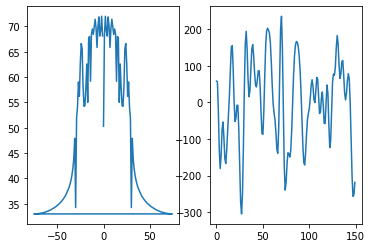

In [8]:
_,ax = plt.subplots(1,2)
ax[0].plot(np.fft.fftfreq(1*srate_down)*srate_down,20*np.log10(np.abs(np.fft.fft(data_in[3,:1*srate_down]))))
ax[1].plot(np.arange(1*srate_down),data_in[3,-1*srate_down:])

In [9]:
# filter dead channels
ch_rms = np.std(data_in,axis=-1)
ch_m = np.mean(ch_rms)
ch_low_lim = ch_m - 2*np.std(ch_rms)
ch_up_lim = ch_m + 2*np.std(ch_rms)
ch_idx = np.logical_and(ch_rms > ch_low_lim, ch_rms < ch_up_lim)
ch_list = np.arange(num_ch)[ch_idx]
num_ch_down = len(ch_list)
print('Filtering Channels:')
print('Num. ch. used:\t{}'.format(num_ch_down))
print('Ch. kept:\t{}\n'.format(ch_list))

Filtering Channels:
Num. ch. used:	56
Ch. kept:	[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57]



In [10]:
#create data tensor
print('Normalizing data, converting to tensor:')
# data_rail = np.max(np.abs(data_in.reshape(-1)))
# normalization = 'zscore'
normalization = 'tanh'
if normalization is 'max':
    data_tensor = torch.from_numpy(data_in[ch_idx,:].view().transpose()/data_rail)
elif normalization is 'zscore':
    # for nominally gaussian data distributions, this will get ~99% of data points in (-1, 1)
    data_tensor = torch.from_numpy(sp.stats.zscore(data_in[ch_idx,:].view().transpose())/5)
elif normalization is 'tanh':
    data_tensor = torch.from_numpy(np.tanh(sp.stats.zscore(data_in[ch_idx,:].view().transpose())/3))
print('Data tensor shape: {}\n'.format(data_tensor.shape))

# create dataset object
print('Creating EcogDataloader dataset object:')
if device == 'cuda:0':
    data_tensor.cuda()
dataset = EcogDataloader.EcogDataset(data_tensor[:,:N_CH_USE],device,seq_len) ## make my own Dataset class
num_ch_down = dataset.n_ch
print('\n')

Normalizing data, converting to tensor:
Data tensor shape: torch.Size([20000, 56])

Creating EcogDataloader dataset object:




In [11]:
# generate sampling index sets
idx_all = np.arange(dataset.data.shape[0])
idx_step = int(np.round(0.1*srate_down))
idx_step = DECODER_DEPTH # no overlapping output sequences
sample_idx = idx_all[:-seq_len:idx_step]
BATCH_SIZE = np.int(np.min((BATCH_SIZE,len(sample_idx))))
# plot samples
n_plot_seed = 1
n_plot_step = 4*seq_len
plot_seed_idx = np.arange(0,n_plot_seed*n_plot_step,n_plot_step)

In [12]:
# # define the network!
# INPUT_DIM = num_ch_down
# OUTPUT_DIM = num_ch_down
# HID_DIM = NUM_HID_DIM

# enc = Encoder.Encoder_GRU(INPUT_DIM, HID_DIM, N_ENC_LAYERS, INPUT_SEQ_LEN, ENC_DROPOUT)
# dec = Decoder.Decoder_GRU(OUTPUT_DIM, HID_DIM, N_DEC_LAYERS, OUTPUT_SEQ_LEN, DEC_DROPOUT)

# model = Seq2Seq.Seq2Seq_GRU(enc, dec, device).to(device)
# model.apply(Util.init_weights) # initialize the model each time.

# print(f'The model has {Util.count_parameters(model):,} trainable parameters')

# criterion = Training.ECOGLoss(sum_axis=1,objective=LOSS_OBJ)
# optimizer = optim.Adam(model.parameters(),lr=LEARN_RATE,weight_decay=weight_reg)
# def create_seq2seq_model(input_dim,hidden_dim,output_dim,in_seq_len,out_seq_len,dropout=ENC_DROPOUT)

In [13]:
# simple progressbar, not tied to the iterator
def print_progress_bar(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

In [14]:
# model training + evaluation function, run this in each parameter choice loop
def train_eval_seq2seq(dataset,n_layers,n_units,l_rate,dropout,save_dir,dry_run=False):
    
#     ENCODER_DEPTH = 250
#     DECODER_DEPTH = 50
#     BATCH_SIZE = 100
#     NUM_EPOCHS = 1500
#     N_EPOCHS = NUM_EPOCHS
    INPUT_SEQ_LEN = ENCODER_DEPTH
    OUTPUT_SEQ_LEN = DECODER_DEPTH
    INPUT_DIM = dataset.data.shape[-1]
    OUTPUT_DIM = dataset.data.shape[-1]
    LOSS_OBJ = 'MSE' #L1, L2, see training.py:ECOGLoss()
    WEIGHT_RANGE = (-0.2,0.2) # ignore for now; not sure how to worm this through
    train_frac = 0.8
    test_frac = 1 - train_frac
    valid_frac = 0.0
    CLIP = 1.
    TFR = 0.
    RAND_SAMP = False
    weight_reg = 0
    enc_len = ENCODER_DEPTH
    dec_len = DECODER_DEPTH
    seq_len = ENCODER_DEPTH+DECODER_DEPTH # use ten time points to predict the next time point
    
    # create model from given spec
    enc = Encoder.Encoder_GRU(INPUT_DIM, n_units, n_layers, INPUT_SEQ_LEN, dropout)
    dec = Decoder.Decoder_GRU(OUTPUT_DIM, n_units, n_layers, OUTPUT_SEQ_LEN, dropout)

    model = Seq2Seq.Seq2Seq_GRU(enc, dec, device).to(device)
    model.apply(Util.init_weights) # initialize the model each time.

    print(f'The model has {Util.count_parameters(model):,} trainable parameters')

    criterion = Training.ECOGLoss(objective=LOSS_OBJ)
    optimizer = optim.Adam(model.parameters(),lr=l_rate,weight_decay=weight_reg)
    
    best_test_loss = float('inf')

    train_loss = np.zeros(N_EPOCHS)
    train_batch_loss = []
    test_loss = np.zeros(N_EPOCHS)
    test_batch_loss = []

    # create training session directory
    time_str = Util.time_str()
#     session_save_path = os.path.join(model_save_dir_path,'enc{}_dec{}_nl{}_nep{}_{}'.format(enc_len,dec_len,N_ENC_LAYERS,N_EPOCHS,time_str))
    param_session_name = 'model_{}'.format(time_str)
    session_save_path = os.path.join(save_dir,param_session_name)
    sequence_plot_path = os.path.join(session_save_path,'example_sequence_figs')
    os.makedirs(session_save_path) # no need to check; there's no way it exists yet.
    os.makedirs(sequence_plot_path)
    print('saving session data to:\t{}'.format(session_save_path))

    if dry_run:
        train_loss = [np.nan]
        test_loss = [np.nan]
    else:
        # make figure (and a place to save it)
        f_loss = plt.figure()
        ax_loss = f_loss.add_subplot(1,1,1)

        for e_idx, epoch in enumerate(range(N_EPOCHS)):
            print_progress_bar(epoch,N_EPOCHS,status='epoch:\t{}'.format(epoch))

            start_time = time.time()

            # get new train/test splits
            # note: add switch to genLoaders to allow for fixed/random sampling
            train_loader, test_loader, _, plot_loader = EcogDataloader.genLoaders(dataset, sample_idx, train_frac, test_frac, valid_frac, BATCH_SIZE, rand_samp=RAND_SAMP, plot_seed=plot_seed_idx)
        #     print('Training Network:')
            _, trbl_ = Training.train(model, train_loader, optimizer, criterion, CLIP, TFR)
            train_batch_loss.append(trbl_)
            train_loss[e_idx] = np.mean(trbl_) # this is the plotted training loss
        #     print('Testing Network:')
            _, tebl_, _ = Training.evaluate(model, test_loader, criterion)
            # test_batch_loss.append(tebl_)
            test_loss[e_idx] = np.mean(tebl_) # this is the plotted test loss
        #     print('Running Figure Sequence:')
            plot_loss, plbl_, plot_data_list = Training.evaluate(model, plot_loader, criterion, plot_flag=True)
            if not (epoch % 10):
        #         print('Saving estimate plots:')
                # save the data for the plotting window in dict form
                epoch_plot_path = os.path.join(sequence_plot_path,'epoch{}'.format(epoch))
                os.makedirs(epoch_plot_path)
                torch.save(model.state_dict(),os.path.join(epoch_plot_path,'model_epoch{}.pt'.format(epoch)))
                c_list = ['b','r']
                for k in range(len(plot_data_list)):
                    c_output = c_list[k//n_plot_seed] # blue for training windows, red for testing windows
                    plot_data_dict = {
                        'src': plot_data_list[k][0],
                        'src_dx': plot_data_list[k][1],
                        'trg': plot_data_list[k][2],
                        'out': plot_data_list[k][3],
                        'enc': plot_data_list[k][4],
                        'dec': plot_data_list[k][5],
                        'srate': srate_down,
                        # 'state_dict': model.state_dict(), # putting this in every file is redundant
                    }
                    torch.save(plot_data_dict,os.path.join(epoch_plot_path,'data_tuple_epoch{}_window{}.pt'.format(epoch,k)))
                    # pass data to plotting function for this window
                    # for plots:
                    # blue: train
                    # red: test
                    # black: real
                    # green: encoder
                    # magenta: decoder
                    f_out, f_enc, f_dec, f_src = Training.eval_plot(plot_data_dict,c_output=c_output)
                    # save plots in current epoch subdir
                    f_out.savefig(os.path.join(epoch_plot_path,'output_plot_epoch{}_window{}.png'.format(epoch,k)))
                    f_enc.savefig(os.path.join(epoch_plot_path,'encoder_plot_epoch{}_window{}.png'.format(epoch,k)))
                    f_dec.savefig(os.path.join(epoch_plot_path,'decoder_plot_epoch{}_window{}.png'.format(epoch,k)))
                    f_src.savefig(os.path.join(epoch_plot_path,'source_plot_epoch{}_window{}.png'.format(epoch,k)))
                    [plt.close(f) for f in [f_out,f_enc,f_dec,f_src]]

            end_time = time.time()

            epoch_mins, epoch_secs = Util.epoch_time(start_time, end_time)

            if test_loss[e_idx] < best_test_loss:
                best_test_loss = test_loss[e_idx]
                torch.save({ # this needs to be made into a model class method!
                        'epoch': epoch,
                        'num_epochs': N_EPOCHS,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_test_loss,
                        'data_path': data_file_full_path,
                        'train_frac': train_frac,
                        'test_frac': test_frac,
                        'batch_size': BATCH_SIZE,
                        'encoder_length': enc_len,
                        'decoder_length': dec_len,
                        }, os.path.join(session_save_path,'model_checkpoint.pt'))

        #     print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        #     print(f'\tTrain Loss: {train_loss[e_idx]:.3g}')
        #     print(f'\t Test Loss: {test_loss[e_idx]:.3g}')
            if e_idx == 0:
                ax_loss.plot(e_idx,train_loss[e_idx],'b.',label='train loss')
                ax_loss.plot(e_idx,test_loss[e_idx],'r.',label='valid. loss')
                ax_loss.legend(loc=0)
            else:
                ax_loss.plot(e_idx,train_loss[e_idx],'b.')
                ax_loss.plot(e_idx,test_loss[e_idx],'r.')
            ax_loss.set_ylim(bottom=0,top=1.05*np.concatenate((train_loss,test_loss)).max())
            # print the loss curve figure; continuously overwrite (like a fun stock ticker)
            f_loss.savefig(os.path.join(session_save_path,'training_progress.png'))
            torch.save({'train_loss':train_loss,'test_loss':test_loss,},os.path.join(session_save_path,'training_progress.pt'))
    return (train_loss, test_loss, param_session_name)

In [ ]:
# sweep over parameters!
# create log file
time_str = Util.time_str()
out_dir = os.path.join(model_save_dir_path,'enc{}_dec{}_hps_{}'.format(enc_len,dec_len,time_str))
os.makedirs(out_dir)
result_file = os.path.join(out_dir,'hps_results.csv')
with open(result_file,'w') as rf:
    rf.write('id,n_layer,n_unit,l_rate,d_rate,train_loss_end,test_loss_end')
    rf.write('\n')
for (n_l,n_u,l_r,d_r) in product(n_layers,n_units,l_rate,dropout):
    train_loss, test_loss, param_session_name = train_eval_seq2seq(dataset,n_l,n_u,l_r,d_r,out_dir)
    with open(result_file,'a') as rf:
        rf.write('{},{},{},{},{},{},{}'.format(param_session_name,n_l,n_u,l_r,d_r,train_loss[-1],test_loss[-1]))
        rf.write('\n')

/home/mickey/miniconda3/envs/ecog_is2s/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


The model has 6,310,913 trainable parameters
saving session data to:	/home/mickey/models/pyt/seq2seq/enc250_dec50_hps_20200701000338458263/model_20200701000403700469
